In [91]:
import numpy as np
import pandas as pd
from aicsimageio import AICSImage

import trackpy as tp
from skimage.filters import gaussian

In [92]:
img = AICSImage('/allen/aics/assay-dev/users/Sandi/pair-up/anthonya/live-cells/modifeid.tiff')
img.shape

(188, 2, 5, 1024, 1024)

# TrackPy test

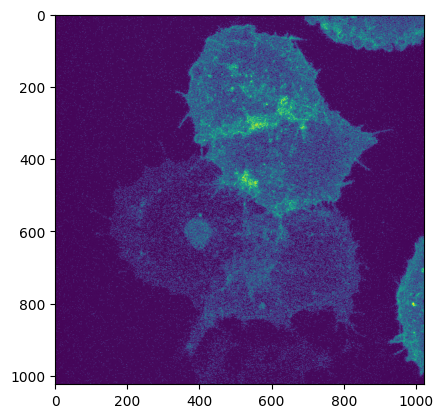

In [93]:
frames = np.max(img.data, axis=2)
# frames = gaussian(frames, 1)

import matplotlib.pyplot as plt
plt.imshow(frames[20,1])

In [94]:
# for t in range(0, frames.shape[0], 10):
#     f = tp.locate(frames[t], 31, invert=False)
#     tp.annotate(f, frames[t])

In [95]:
# f = tp.locate(frames, 31, invert=False)
# t = tp.link(f, 15, memory=3)

# Motion Correction - skimage

In [96]:
from skimage.registration import phase_cross_correlation
from skimage.exposure import rescale_intensity

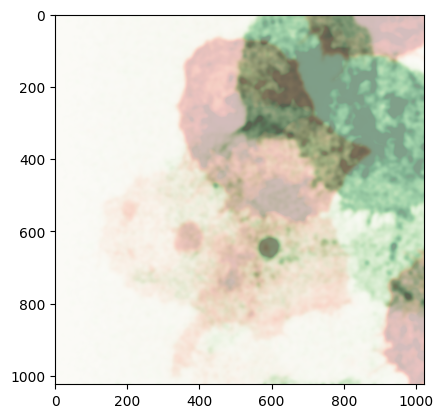

In [97]:
frame1 = gaussian(frames[0,1], 5)
frame2 = gaussian(frames[180,1], 5)

p5, p95 = np.percentile(frame1, (5, 95))
frame1 = np.clip(frame1, p5, p95)
frame1 = rescale_intensity(frame1, out_range=np.uint8)

p5, p95 = np.percentile(frame2, (5, 95))
frame2 = np.clip(frame2, p5, p95)
frame2 = rescale_intensity(frame2, out_range=np.uint8)

plt.figure()
plt.imshow(frame1, cmap='Reds', alpha=0.5)
plt.imshow(frame2, cmap='Greens', alpha=0.5)

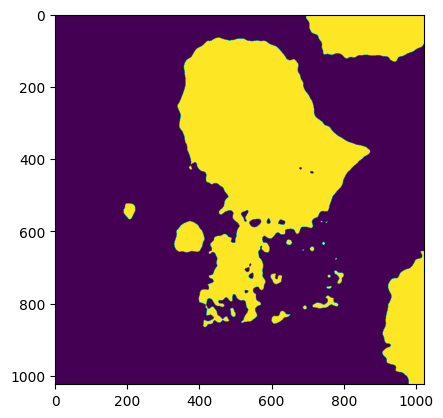

In [98]:
from skimage.filters import threshold_otsu

thresh = threshold_otsu(frame1)
binary = frame1 > thresh

plt.figure()
plt.imshow(binary)

[ 148. -142.]


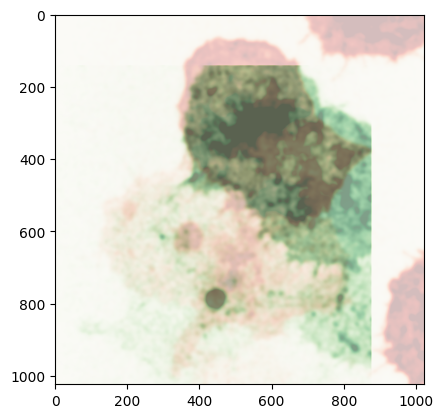

In [99]:
shift, _, _ = phase_cross_correlation(
    frame1, 
    frame2, 
    upsample_factor=20,
    reference_mask=binary,
)
print(shift)

from skimage.transform import warp, SimilarityTransform
tform = SimilarityTransform(translation=(shift[0], shift[1]))
frame2_shift = warp(frame2, tform)

plt.figure()
plt.imshow(frame1, cmap='Reds', alpha=0.5)
plt.imshow(frame2_shift, cmap='Greens', alpha=0.5)

In [114]:
from tqdm import tqdm
from skimage.morphology import binary_dilation, disk, remove_small_objects, remove_small_holes

def segment(img):
    p5, p95 = np.percentile(img, (5, 95))
    img = np.clip(img, p5, p95)
    img = rescale_intensity(img, out_range=np.uint8)
    
    thresh = threshold_otsu(img)
    binary = img > thresh
    
    binary = remove_small_objects(binary, 100)
    binary = remove_small_holes(binary, 500)
    binary = binary_dilation(binary, disk(15))
    
    return binary

def correct_motion(sequence, kernel_size=11, refresh=25):
    seq_smoothed = np.zeros_like(sequence, dtype=np.uint16)
    seq_smoothed[0] = sequence[0]
    
    reference = gaussian(sequence[0], kernel_size)
    ref_bin = segment(reference)
    
    shifts = []
    for t in tqdm(range(1, sequence.shape[0])):
        if t % refresh == 0:
            reference = gaussian(seq_smoothed[t-1], kernel_size)
            ref_bin = segment(reference)
        
        moving = gaussian(sequence[t], kernel_size)
        mov_bin = segment(moving)
        
        reference = rescale_intensity(reference, out_range=np.uint16)
        moving = rescale_intensity(moving, out_range=np.uint16)
        
        shift, _, _ = phase_cross_correlation(
            reference, 
            moving, 
            upsample_factor=20,
            reference_mask=ref_bin,
            moving_mask=mov_bin,
        )
        shifts.append(shift)
        tform = SimilarityTransform(translation=(shift[0], shift[1]))
        seq_smoothed[t] = rescale_intensity(
            warp(sequence[t], tform, preserve_range=True),
            out_range=np.uint16
        )
        
    return seq_smoothed, np.stack(shifts, axis=0)

In [115]:
smooth_frames, shifts = correct_motion(frames[:,1,...])

100%|██████████| 187/187 [04:59<00:00,  1.60s/it]


In [116]:
# from aicsimageio.writers import OmeTiffWriter

# OmeTiffWriter.save(smooth_frames, 'smoothed.tiff')

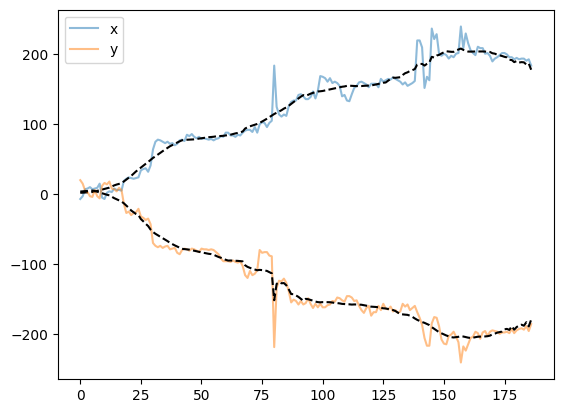

In [118]:
from scipy.signal import wiener

plt.figure()
plt.plot(shifts[:,0], label='x', alpha=0.5)
plt.plot(wiener(shifts[:,0], 25), 'k--')
plt.plot(shifts[:,1], label='y', alpha=0.5)
plt.plot(wiener(shifts[:,1], 25), 'k--')
plt.legend()

In [119]:
shifts_smooths = np.stack([
    wiener(shifts[:,0], 25),
    wiener(shifts[:,1], 25)
], axis=1)

data_smoothed = np.zeros_like(img.data, dtype=np.uint16)
for t in tqdm(range(img.data.shape[0])):
    if t == 0:
        data_smoothed[t] = rescale_intensity(img.data[t], out_range=np.uint16)
        continue
    tform = SimilarityTransform(translation=(shifts_smooths[t-1,0], shifts_smooths[t-1,1]))
    for z in range(img.data.shape[2]):
        for c in range(img.data.shape[1]):
            data_smoothed[t,c,z,...] = rescale_intensity(
                warp(img.data[t,c,z,...], tform, preserve_range=True, order=0),
                out_range=np.uint16
            )

100%|██████████| 188/188 [02:17<00:00,  1.37it/s]


In [136]:
OmeTiffWriter.save(data_smoothed, 'results/data_smoothed.tiff')
OmeTiffWriter.save(data_smoothed[:,1,...], 'results/data_smoothed_green.tiff')
OmeTiffWriter.save(data_smoothed[:,0,...], 'results/data_smoothed_red.tiff')

## TrackPy test

In [121]:
frames = np.max(data_smoothed[:,0,...], axis=1)
for t in range(0, frames.shape[0], 10):
    frames[t] = gaussian(frames[t], 5, preserve_range=True)
frames = rescale_intensity(frames, out_range=(0,1))
frames.shape

(188, 1024, 1024)

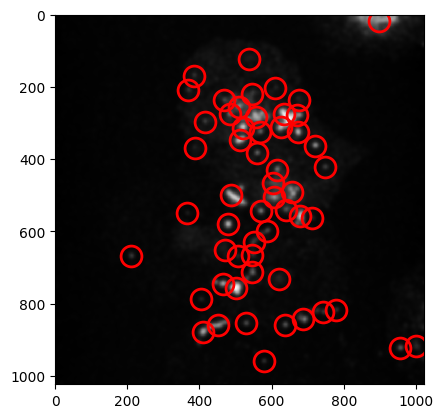

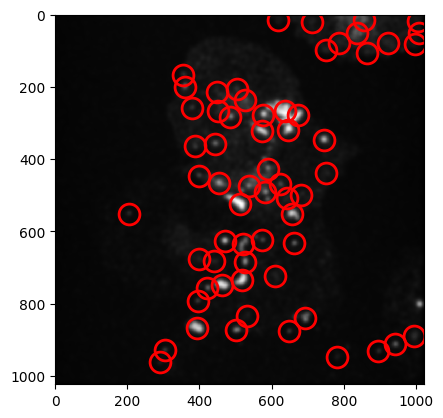

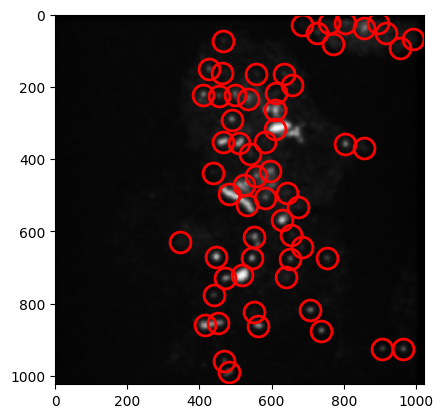

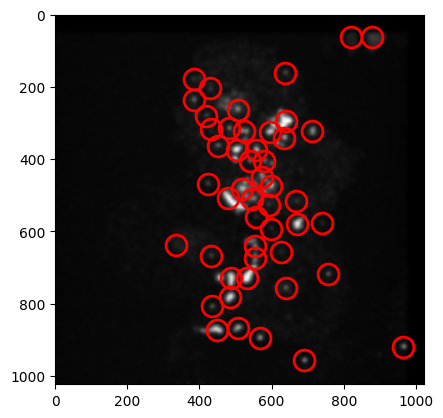

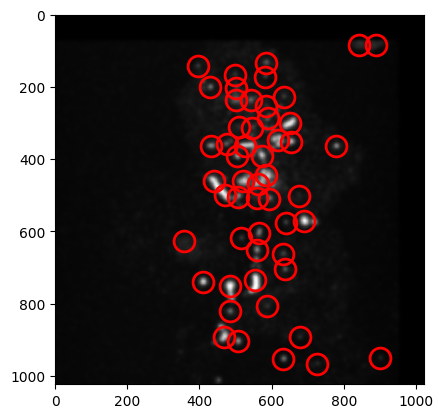

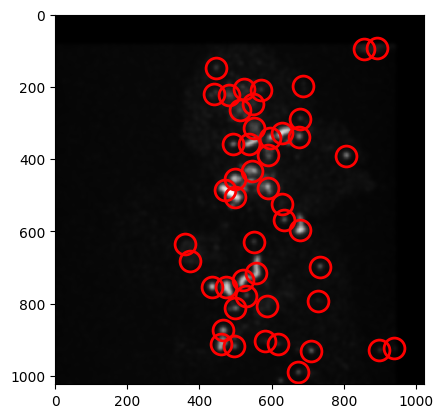

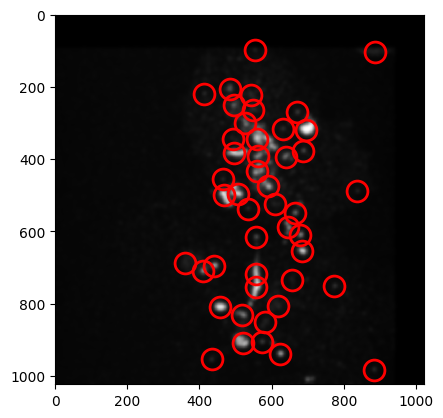

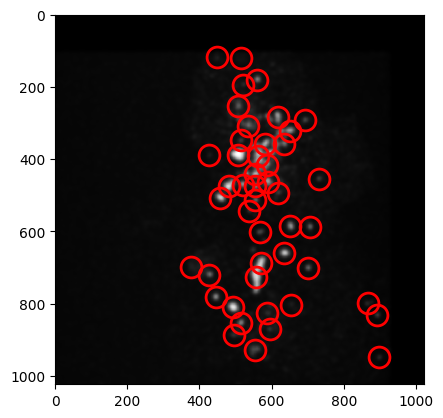

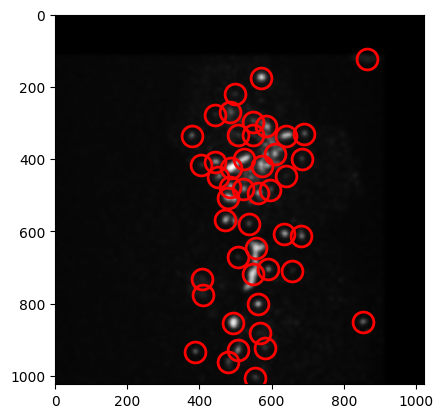

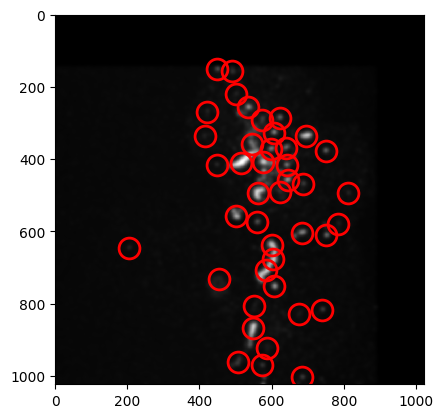

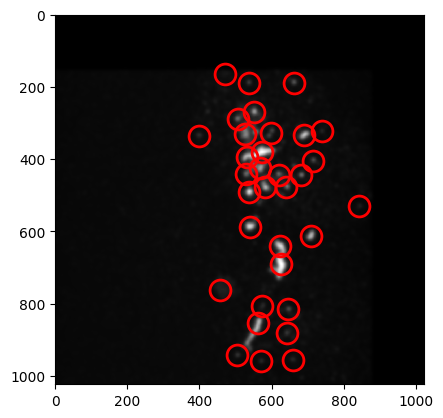

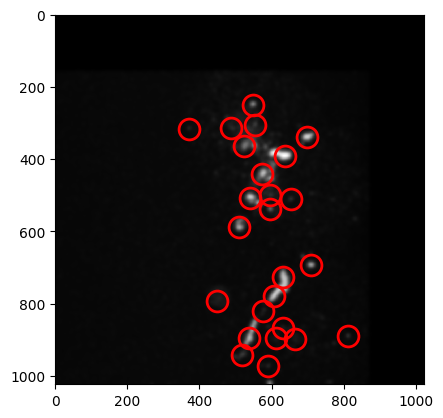

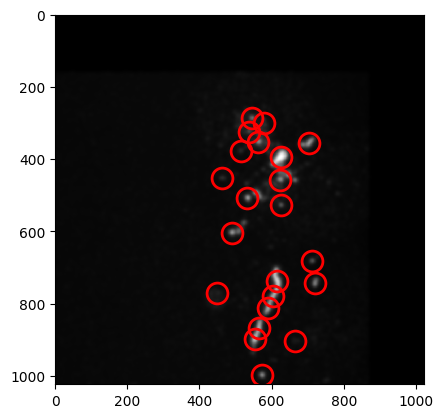

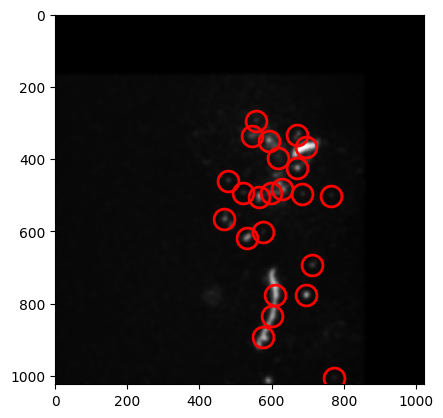

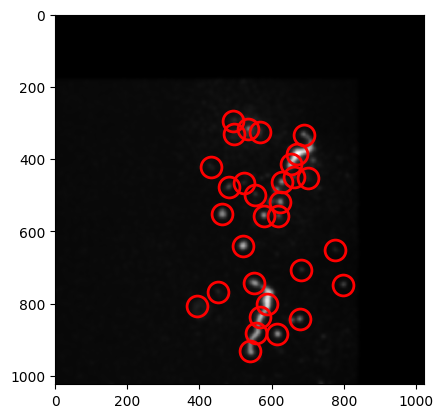

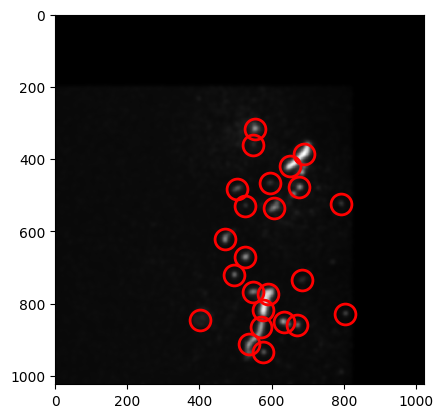

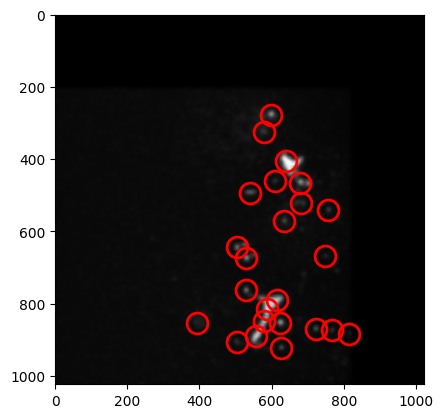

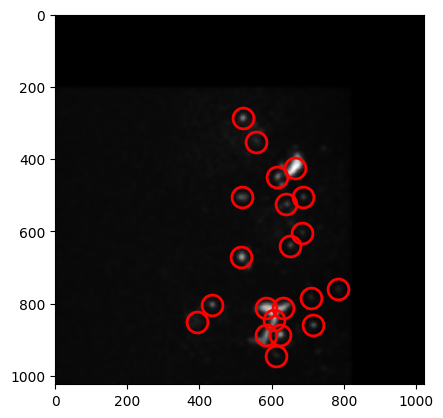

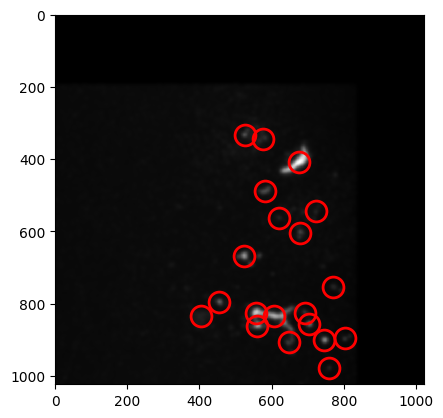

In [122]:
for t in range(0, frames.shape[0], 25):
    f = tp.locate(frames[t], 31, invert=False, minmass=5)
    tp.annotate(f, frames[t])

In [123]:
f = tp.batch(frames, 31, invert=False, minmass=60)
f.head()

Frame 187: 4 features


,y,x,mass,size,ecc,signal,raw_mass,ep,frame
0,274.415412,633.273961,80.309027,8.396639,0.322631,0.308308,417.805997,0.002969,0
1,283.056014,557.129050,60.811151,8.896340,0.135090,0.187666,343.752300,0.003644,0
2,312.084829,519.687843,60.977965,6.420834,0.061164,0.361927,277.634928,0.004573,0
3,347.677983,512.423247,84.364692,8.032526,0.314889,0.342564,295.580087,0.004277,0
4,500.302274,487.433993,81.074584,8.999100,0.438120,0.277030,321.035767,0.003917,0


In [134]:
t = tp.link(f, 20, memory=3)
t = tp.filter_stubs(t, 5)

Frame 187: 4 trajectories present.


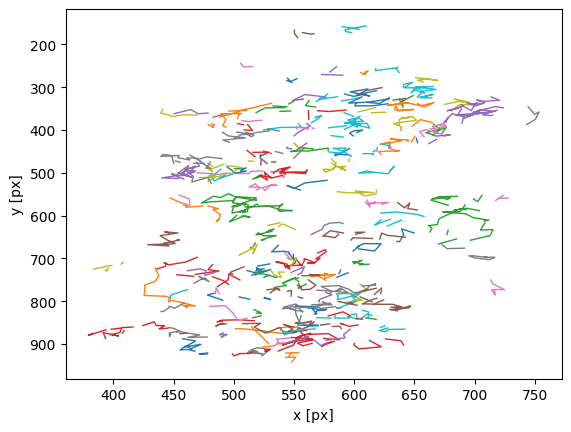

<Axes: xlabel='x [px]', ylabel='y [px]'>

In [135]:
tp.plot_traj(t)

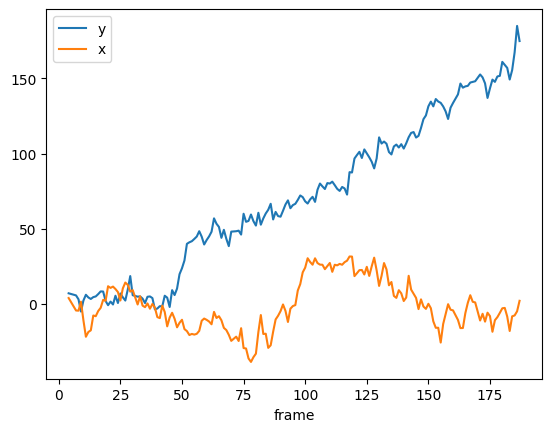

In [130]:
d = tp.compute_drift(t)
d.plot()
plt.show()

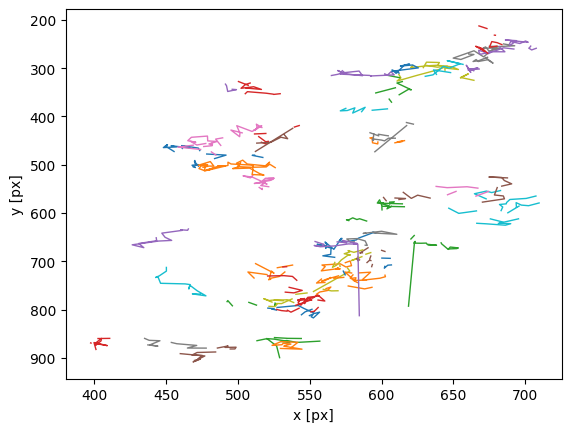

In [131]:
tm = tp.subtract_drift(t.copy(), d)

ax=tp.plot_traj(tm)
plt.show()